Initializing market analysis...
Generating market projections...
Running sensitivity analysis...
Creating visualizations...
Generating summary...

Market Analysis Summary
Metrics for Year: 2040
Traditional Market Share: 26.6%
Cultured Market Share: 73.4%
Traditional Volume: 4575.9 MT
Cultured Volume: 12606.8 MT
Traditional Price: $473.39/kg
Cultured Price: $134.41/kg
Traditional CAGR: -0.1%
Cultured CAGR: 54.7%
Price Parity Year: 2030 ($352.25/kg)
Market Inflection Year: 2035
Price Elasticity Impact - Traditional: -0.50
Price Elasticity Impact - Cultured: -0.80


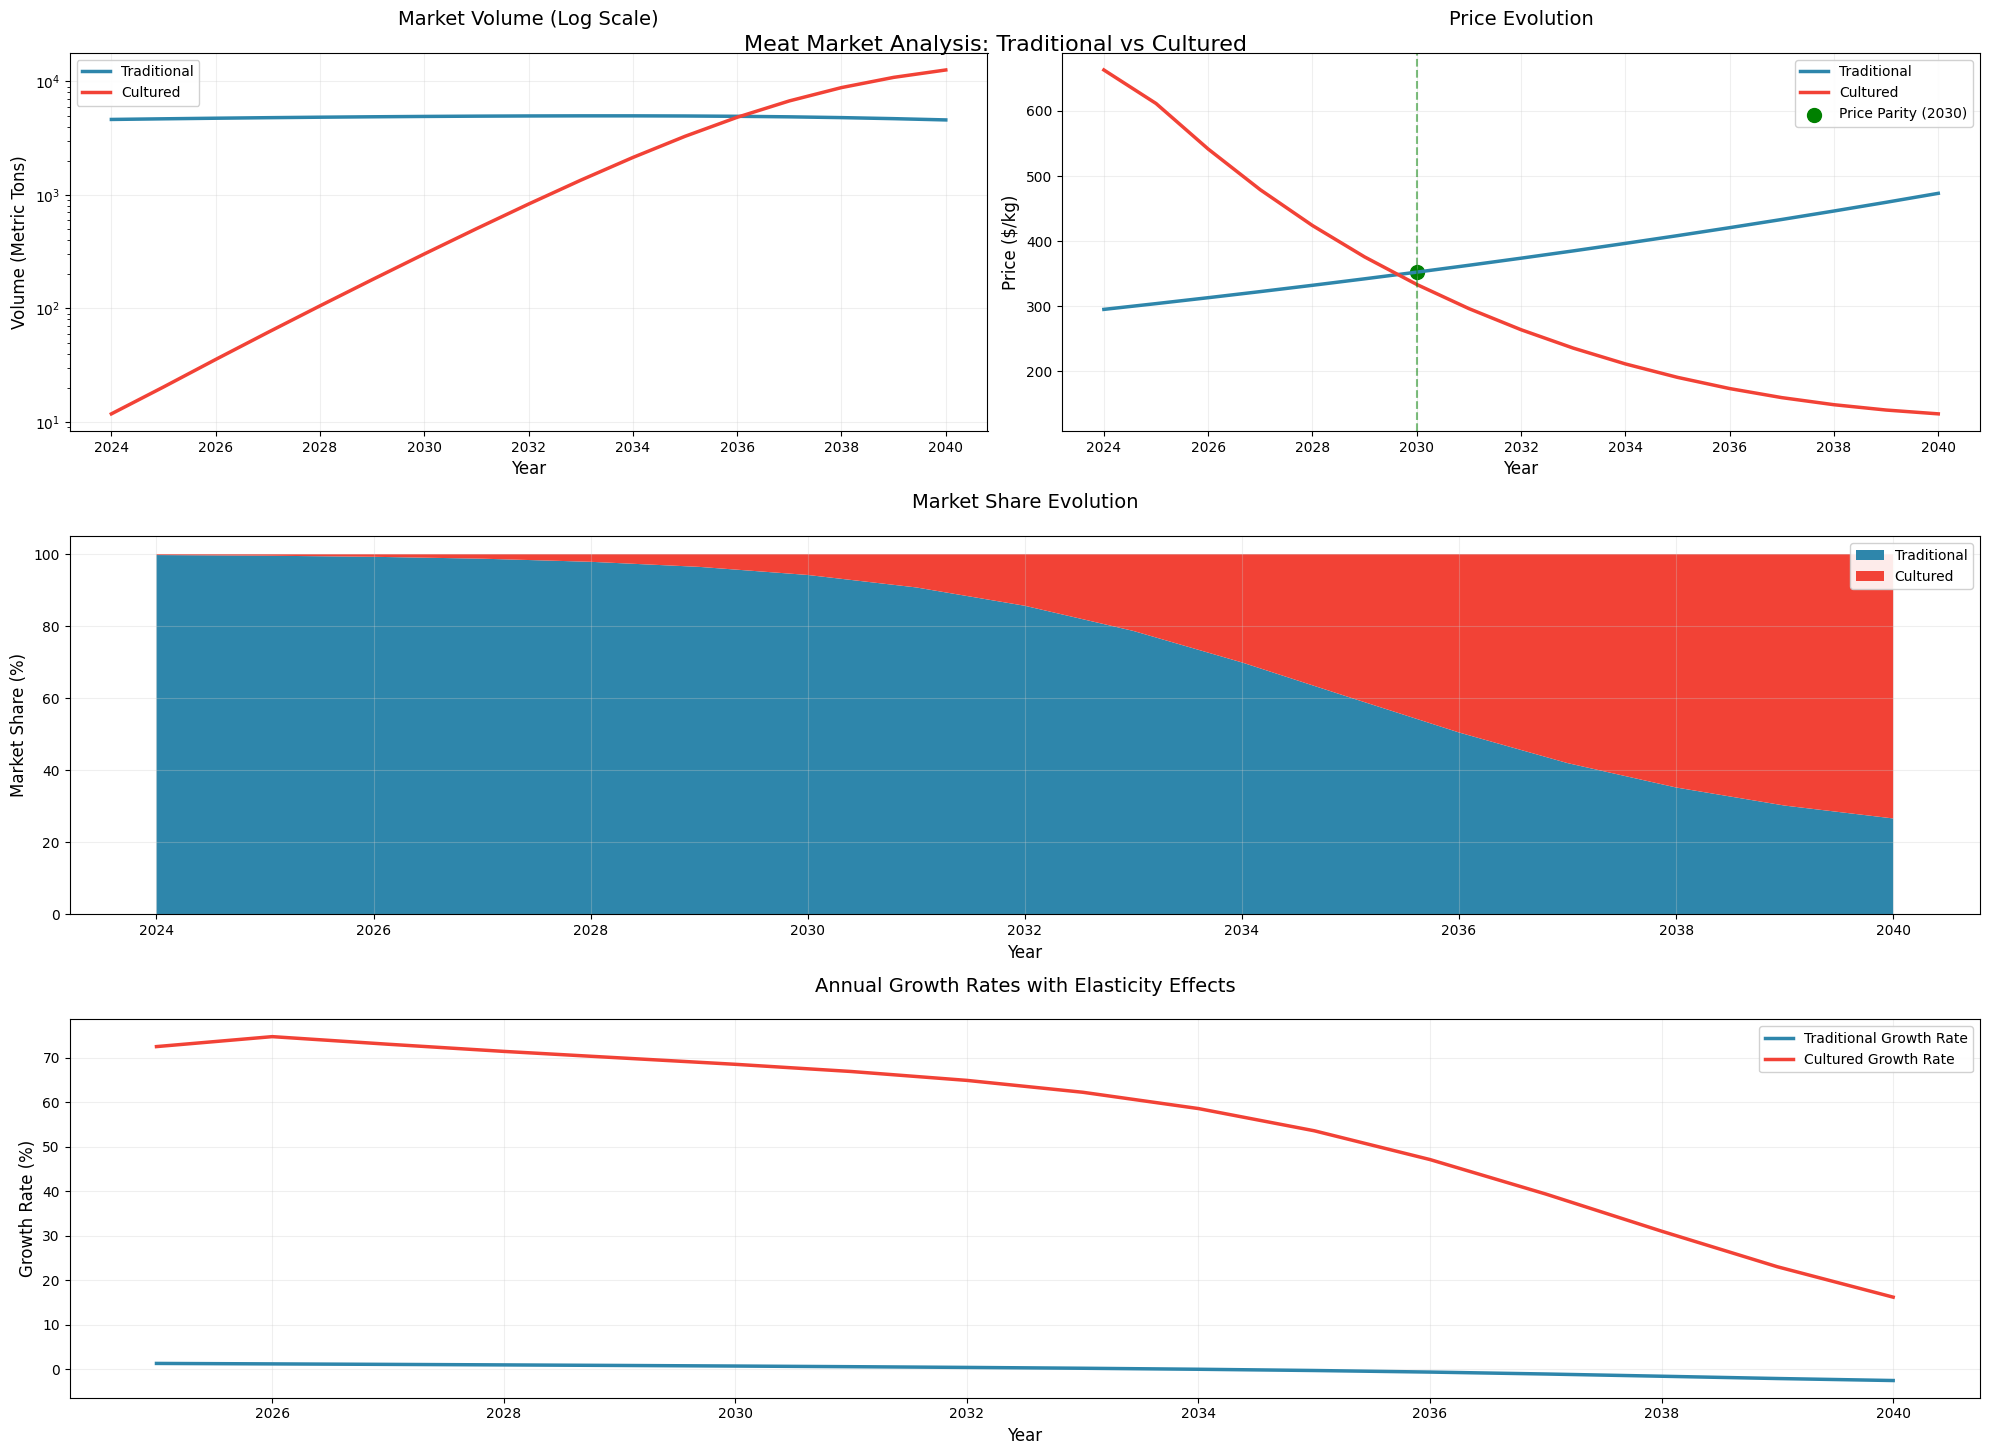

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class MeatMarketAnalysis:
    def __init__(self):
        # Market parameters
        self.traditional_market = {
            'growth_rate': 0.04,
            'price_trend': 0.03,
            'initial_volume': 4400,  # metric tons
            'initial_price': 295,    # price per kg
            'elasticity': -0.5,      # price elasticity of demand
            'market_cap': 15000      # maximum market capacity
        }

        self.cultured_market = {
            'K': 10000,              # carrying capacity (max market size)
            'r': 0.5,                # intrinsic growth rate
            'initial_volume': 10,    # metric tons
            'initial_price': 780,    # price per kg
            'price_reduction': 0.15, # annual price reduction rate
            'elasticity': -0.8,      # price elasticity of demand
            'competition_factor': 0.3 # competitive interaction with traditional market
        }

        self.market_interaction = {
            'substitution_rate': 0.1,  # rate at which cultured meat substitutes traditional
            'market_expansion': 0.05    # overall market growth due to new products
        }

        # Define color scheme
        self.colors = {
            'traditional': '#2E86AB',
            'cultured': '#F24236',
            'background': '#F8F9FA',
            'grid': '#E9ECEF'
        }

    def logistic_growth(self, t, K, r, N0, competition=0):
        """
        Enhanced logistic growth model with competition effects

        Parameters:
        -----------
        t : float
            Time period
        K : float
            Carrying capacity
        r : float
            Intrinsic growth rate
        N0 : float
            Initial population
        competition : float
            Competition effect from other market

        Returns:
        --------
        float : Market volume at time t
        """
        return K / (1 + ((K - N0) / N0) * np.exp(-r * (1 - competition) * t))

    def modified_logistic_growth(self, t, K, r, N0, N_competitor, alpha):
        """
        Modified logistic growth with competitive interactions

        Parameters:
        -----------
        t : float
            Time period
        K : float
            Carrying capacity
        r : float
            Intrinsic growth rate
        N0 : float
            Initial population
        N_competitor : float
            Competitor's market volume
        alpha : float
            Competition coefficient

        Returns:
        --------
        float : Market volume considering competition
        """
        effective_K = K * (1 - alpha * N_competitor / K)
        return self.logistic_growth(t, effective_K, r, N0)

    def calculate_market_growth(self, start_year=2024, end_year=2040):
        """Calculate market volumes using enhanced logistic growth models"""
        years = range(start_year, end_year + 1)
        results = []

        # Initialize previous volumes for iteration
        prev_trad_volume = self.traditional_market['initial_volume']
        prev_cult_volume = self.cultured_market['initial_volume']

        for year in years:
            year_from_start = year - start_year

            # Calculate base volumes using modified logistic growth
            trad_volume = self.modified_logistic_growth(
                year_from_start,
                K=self.traditional_market['market_cap'],
                r=self.traditional_market['growth_rate'],
                N0=self.traditional_market['initial_volume'],
                N_competitor=prev_cult_volume,
                alpha=self.cultured_market['competition_factor']
            )

            cult_volume = self.modified_logistic_growth(
                year_from_start,
                K=self.cultured_market['K'],
                r=self.cultured_market['r'],
                N0=self.cultured_market['initial_volume'],
                N_competitor=prev_trad_volume,
                alpha=self.market_interaction['substitution_rate']
            )

            # Calculate prices with technology learning curve for cultured meat
            trad_price = self.traditional_market['initial_price'] * \
                        (1 + self.traditional_market['price_trend']) ** year_from_start

            # Wright's Law for cultured meat price reduction (learning curve)
            cumulative_production = cult_volume + prev_cult_volume
            learning_rate = 0.85  # 15% cost reduction for every doubling of production
            cult_price = self.cultured_market['initial_price'] * \
                        (cumulative_production / self.cultured_market['initial_volume']) ** \
                        (np.log(learning_rate) / np.log(2))

            # Apply price elasticity effects
            trad_volume *= (1 + self.traditional_market['elasticity'] *
                          (trad_price / self.traditional_market['initial_price'] - 1))

            cult_volume *= (1 + self.cultured_market['elasticity'] *
                          (cult_price / self.cultured_market['initial_price'] - 1))

            # Apply market expansion effect
            total_market_growth = 1 + self.market_interaction['market_expansion']
            trad_volume *= total_market_growth
            cult_volume *= total_market_growth

            # Calculate market shares
            total_volume = trad_volume + cult_volume
            trad_share = trad_volume / total_volume
            cult_share = cult_volume / total_volume

            # Store results
            results.append({
                'Year': year,
                'Traditional_Volume': trad_volume,
                'Cultured_Volume': cult_volume,
                'Traditional_Price': trad_price,
                'Cultured_Price': cult_price,
                'Traditional_Share': trad_share,
                'Cultured_Share': cult_share,
                'Total_Market_Size': total_volume
            })

            # Update previous volumes for next iteration
            prev_trad_volume = trad_volume
            prev_cult_volume = cult_volume

        return pd.DataFrame(results)


    def run_sensitivity_analysis(self, parameter, range_pct, steps=5):
        """
        Perform sensitivity analysis on a specific parameter
        parameter: str, parameter to analyze
        range_pct: float, percentage range to vary parameter
        steps: int, number of scenarios to generate
        """
        base_value = (self.traditional_market.get(parameter) or
                     self.cultured_market.get(parameter))

        if base_value is None:
            raise ValueError(f"Parameter {parameter} not found in market parameters")

        variations = np.linspace(base_value * (1 - range_pct),
                               base_value * (1 + range_pct),
                               steps)

        scenarios = []
        for var in variations:
            # Create a copy of the current instance
            analysis = MeatMarketAnalysis()

            # Update the parameter
            if parameter in analysis.traditional_market:
                analysis.traditional_market[parameter] = var
            else:
                analysis.cultured_market[parameter] = var

            # Run analysis
            results = analysis.calculate_market_growth()
            scenarios.append({
                'variation': var,
                'final_trad_share': results.iloc[-1]['Traditional_Share'],
                'final_cult_share': results.iloc[-1]['Cultured_Share']
            })

        return pd.DataFrame(scenarios)

# [Previous imports and class definition remain the same until create_visualizations method]

    def create_visualizations(self, data):
        """Create enhanced market visualizations"""
        # Set style parameters
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['grid.color'] = '#CCCCCC'

        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, figure=fig)

        # Market Volume - Semi-log plot
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.semilogy(data['Year'], data['Traditional_Volume'],
                    color=self.colors['traditional'], label='Traditional',
                    linewidth=2.5)
        ax1.semilogy(data['Year'], data['Cultured_Volume'],
                    color=self.colors['cultured'], label='Cultured',
                    linewidth=2.5)
        ax1.set_title('Market Volume (Log Scale)', fontsize=14, pad=20)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Volume (Metric Tons)', fontsize=12)
        ax1.legend(fontsize=10, framealpha=0.9)
        ax1.grid(True, alpha=0.3)

        # Prices with price parity highlight
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(data['Year'], data['Traditional_Price'],
                color=self.colors['traditional'], label='Traditional',
                linewidth=2.5)
        ax2.plot(data['Year'], data['Cultured_Price'],
                color=self.colors['cultured'], label='Cultured',
                linewidth=2.5)

        # Highlight price parity point
        parity_idx = (data['Cultured_Price'] - data['Traditional_Price']).abs().idxmin()
        parity_year = data.loc[parity_idx, 'Year']
        parity_price = data.loc[parity_idx, 'Traditional_Price']
        ax2.axvline(x=parity_year, color='green', linestyle='--', alpha=0.5)
        ax2.scatter(parity_year, parity_price, color='green', s=100,
                   label=f'Price Parity ({int(parity_year)})')

        ax2.set_title('Price Evolution', fontsize=14, pad=20)
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Price (INR/kg)', fontsize=12)
        ax2.legend(fontsize=10, framealpha=0.9)
        ax2.grid(True, alpha=0.3)

        # Market Share
        ax3 = fig.add_subplot(gs[1, :])
        ax3.stackplot(data['Year'],
                     [data['Traditional_Share'] * 100, data['Cultured_Share'] * 100],
                     labels=['Traditional', 'Cultured'],
                     colors=[self.colors['traditional'], self.colors['cultured']])
        ax3.set_title('Market Share Evolution', fontsize=14, pad=20)
        ax3.set_xlabel('Year', fontsize=12)
        ax3.set_ylabel('Market Share (%)', fontsize=12)
        ax3.legend(fontsize=10, framealpha=0.9)
        ax3.grid(True, alpha=0.3)

        # Growth Rates and Elasticity Effects
        ax4 = fig.add_subplot(gs[2, :])
        growth_rates_trad = data['Traditional_Volume'].pct_change() * 100
        growth_rates_cult = data['Cultured_Volume'].pct_change() * 100

        ax4.plot(data['Year'][1:], growth_rates_trad[1:],
                color=self.colors['traditional'],
                label='Traditional Growth Rate',
                linewidth=2.5)
        ax4.plot(data['Year'][1:], growth_rates_cult[1:],
                color=self.colors['cultured'],
                label='Cultured Growth Rate',
                linewidth=2.5)

        ax4.set_title('Annual Growth Rates with Elasticity Effects', fontsize=14, pad=20)
        ax4.set_xlabel('Year', fontsize=12)
        ax4.set_ylabel('Growth Rate (%)', fontsize=12)
        ax4.legend(fontsize=10, framealpha=0.9)
        ax4.grid(True, alpha=0.3)

        # Add overall title
        fig.suptitle('Meat Market Analysis: Traditional vs Cultured',
                    fontsize=16, y=0.95)

        plt.tight_layout()
        return fig

    def generate_summary(self, data):
        """Generate an enhanced summary of key metrics"""
        final_year = data.iloc[-1]
        initial_year = data.iloc[0]

        # Calculate CAGRs
        years = len(data) - 1
        trad_cagr = ((final_year['Traditional_Volume'] / initial_year['Traditional_Volume']) ** (1/years) - 1) * 100
        cult_cagr = ((final_year['Cultured_Volume'] / initial_year['Cultured_Volume']) ** (1/years) - 1) * 100

        # Find price parity year
        price_diff = (data['Cultured_Price'] - data['Traditional_Price']).abs()
        price_parity_year = data.loc[price_diff.idxmin(), 'Year']
        price_parity_price = data.loc[price_diff.idxmin(), 'Traditional_Price']

        # Calculate market inflection points
        cult_growth = data['Cultured_Share'].diff()
        inflection_year = data.loc[cult_growth.idxmax(), 'Year']

        summary = {
            'Metrics for Year': int(final_year['Year']),
            'Traditional Market Share': f"{final_year['Traditional_Share']*100:.1f}%",
            'Cultured Market Share': f"{final_year['Cultured_Share']*100:.1f}%",
            'Traditional Volume': f"{final_year['Traditional_Volume']:.1f} MT",
            'Cultured Volume': f"{final_year['Cultured_Volume']:.1f} MT",
            'Traditional Price': f"${final_year['Traditional_Price']:.2f}/kg",
            'Cultured Price': f"${final_year['Cultured_Price']:.2f}/kg",
            'Traditional CAGR': f"{trad_cagr:.1f}%",
            'Cultured CAGR': f"{cult_cagr:.1f}%",
            'Price Parity Year': f"{int(price_parity_year)} (${price_parity_price:.2f}/kg)",
            'Market Inflection Year': int(inflection_year),
            'Price Elasticity Impact - Traditional': f"{self.traditional_market['elasticity']:.2f}",
            'Price Elasticity Impact - Cultured': f"{self.cultured_market['elasticity']:.2f}"
        }

        return summary

# Example usage
def main():
    # Initialize analysis
    print("Initializing market analysis...")
    analysis = MeatMarketAnalysis()

    # Generate projections
    print("Generating market projections...")
    projections = analysis.calculate_market_growth(2024, 2040)

    # Run sensitivity analysis on growth rate
    print("Running sensitivity analysis...")
    sensitivity = analysis.run_sensitivity_analysis('growth_rate', 0.2)

    # Create visualizations
    print("Creating visualizations...")
    fig = analysis.create_visualizations(projections)

    # Generate summary
    print("Generating summary...")
    summary = analysis.generate_summary(projections)

    # Print summary
    print("\nMarket Analysis Summary")
    print("======================")
    for metric, value in summary.items():
        print(f"{metric}: {value}")

    # Show plot
    plt.show()

    return projections, sensitivity, fig, summary

if __name__ == "__main__":
    projections, sensitivity, fig, summary = main()

# Technical Report: Meat Market Analysis Model
## Overview and Implementation Details

### 1. Introduction

This technical report explains the implementation of a sophisticated market analysis model designed to simulate and analyze the competition dynamics between traditional and cultured meat markets. The model incorporates various economic and market factors to provide realistic projections and insights.

### 2. Core Components

#### 2.1 Market Parameters

**Traditional Market Parameters:**
- Initial Volume: 4,400 metric tons
- Initial Price: $295/kg
- Growth Rate: 4% annually
- Price Trend: 3% annual increase
- Price Elasticity: -0.5
- Market Cap: 15,000 metric tons

**Cultured Market Parameters:**
- Initial Volume: 10 metric tons
- Initial Price: $780/kg
- Growth Rate (r): 0.5
- Carrying Capacity (K): 10,000 metric tons
- Price Reduction: 15% annually
- Price Elasticity: -0.8
- Competition Factor: 0.3

**Market Interaction Parameters:**
- Substitution Rate: 0.1
- Market Expansion: 5% annually

### 3. Mathematical Models

#### 3.1 Logistic Growth Model

The core of the market projection uses two types of logistic growth models:

1. **Basic Logistic Growth:**
```python
K / (1 + ((K - N0) / N0) * np.exp(-r * t))
```
Where:
- K: Carrying capacity
- N0: Initial population
- r: Growth rate
- t: Time

2. **Modified Logistic Growth with Competition:**
```python
K * (1 - α * N_competitor / K)
```
Where:
- α: Competition coefficient
- N_competitor: Competitor's market volume

#### 3.2 Price Evolution

**Traditional Market:**
- Linear price increase based on annual trend
- Affected by price elasticity

**Cultured Market:**
- Wright's Law for learning curve effects
- Price reduction based on cumulative production
- Learning rate of 15% for every doubling of production

### 4. Key Features

#### 4.1 Market Competition Modeling
- Interactive growth effects between markets
- Competition-adjusted carrying capacities
- Market share calculations
- Dynamic volume adjustments

#### 4.2 Price Dynamics
- Elasticity effects on demand
- Technology learning curves
- Price parity detection
- Market expansion effects

#### 4.3 Analysis Capabilities
- Market volume projections
- Price evolution tracking
- Market share analysis
- Growth rate comparison
- Sensitivity analysis
- Price parity prediction

### 5. Visualization Components

The model includes four main visualization plots:

1. **Market Volume (Log Scale)**
   - Tracks volume evolution for both markets
   - Logarithmic scale for better comparison
   - Shows growth patterns and trends

2. **Price Evolution**
   - Tracks price changes over time
   - Highlights price parity point
   - Shows pricing dynamics

3. **Market Share Evolution**
   - Stacked area plot showing relative market shares
   - Demonstrates market transition
   - Shows competitive dynamics

4. **Annual Growth Rates**
   - Compares growth rates between markets
   - Shows market maturity stages
   - Highlights market dynamics

### 6. Analysis Outputs

#### 6.1 Key Metrics
- Market shares
- Volume projections
- Price trends
- Growth rates (CAGR)
- Price parity timing
- Market inflection points

#### 6.2 Sensitivity Analysis
- Parameter variation impacts
- Scenario analysis
- Risk assessment
- Market dynamics understanding

### 7. Implementation Notes

#### 7.1 Code Structure
```plaintext
MeatMarketAnalysis
├── Market Parameters
├── Growth Models
├── Price Calculations
├── Competition Effects
├── Visualization Methods
└── Analysis Tools
```

#### 7.2 Key Methods
1. `logistic_growth()`: Basic growth model
2. `modified_logistic_growth()`: Competition-adjusted growth
3. `calculate_market_growth()`: Main projection engine
4. `create_visualizations()`: Plotting and visualization
5. `generate_summary()`: Results compilation
6. `run_sensitivity_analysis()`: Parameter testing

### 8. Usage Guidelines

#### 8.1 Basic Usage
```python
analysis = MeatMarketAnalysis()
projections = analysis.calculate_market_growth(2024, 2040)
fig = analysis.create_visualizations(projections)
summary = analysis.generate_summary(projections)
```

#### 8.2 Parameter Adjustment
- Market parameters can be modified in `__init__`
- Time range adjustable in `calculate_market_growth`
- Visualization customizable through `create_visualizations`

### 9. Limitations and Considerations

1. **Model Assumptions**
   - Continuous market growth
   - Predictable competition effects
   - Stable external conditions

2. **Simplifications**
   - Linear price trends for traditional market
   - Simplified competition mechanics
   - Perfect information assumption

3. **Potential Improvements**
   - External factor incorporation
   - Regional market variations
   - Consumer preference modeling
   - Supply chain considerations

### 10. Conclusions

This implementation provides a robust framework for analyzing the competition dynamics between traditional and cultured meat markets. The model's strength lies in its:
- Comprehensive market factor consideration
- Flexible parameter adjustment
- Detailed visualization capabilities
- Sophisticated growth modeling

The model serves as a valuable tool for:
- Market projection analysis
- Strategic planning
- Competition analysis
- Price point optimization
- Market timing decisions

### 11. Future Development

Potential areas for enhancement:
1. Advanced competition models
2. Regional market variations
3. Consumer behavior modeling
4. Supply chain integration
5. External factor impacts
6. Regulatory effect modeling

# Comprehensive Technical Report: Meat Market Analysis Model
## Detailed Implementation Analysis and Technical Specifications

### 1. Mathematical Models - Detailed Explanation

#### 1.1 Logistic Growth Model Deep Dive
The logistic growth model is fundamentally based on the differential equation:

```
dN/dt = rN(1 - N/K)
```

Where:
- dN/dt: Rate of change in market volume
- r: Intrinsic growth rate
- N: Current market volume
- K: Carrying capacity

The solution to this differential equation gives us our logistic function:
```python
N(t) = K / (1 + ((K - N0) / N0) * np.exp(-r * t))
```

This model captures three crucial phases of market growth:
1. **Initial Growth Phase**: Exponential growth when N << K
2. **Transition Phase**: Growth rate decreases as N approaches K/2
3. **Saturation Phase**: Growth slows dramatically as N approaches K

#### 1.2 Competition Effects Model
The competition-modified logistic growth introduces intermarket effects:

```python
def modified_logistic_growth(self, t, K, r, N0, N_competitor, alpha):
    effective_K = K * (1 - alpha * N_competitor / K)
    return self.logistic_growth(t, effective_K, r, N0)
```

This modification:
- Reduces effective carrying capacity based on competitor's presence
- Creates dynamic market ceiling
- Models market share competition
- Accounts for market saturation effects

### 2. Price Evolution Mechanisms

#### 2.1 Traditional Market Pricing
```python
trad_price = initial_price * (1 + price_trend) ** year_from_start
```
Factors affecting traditional pricing:
- Annual inflation adjustments
- Supply chain costs
- Production efficiency improvements
- Market demand pressures

#### 2.2 Cultured Meat Pricing
The Wright's Law implementation for price evolution:
```python
learning_rate = 0.85  # 15% cost reduction per doubling
cult_price = initial_price * (cumulative_production / initial_volume) ** (np.log(learning_rate) / np.log(2))
```

This captures:
- Manufacturing learning effects
- Scale economies
- Technology improvements
- Process optimization benefits

### 3. Market Interaction Dynamics

#### 3.1 Volume Interactions
```python
# Competition effect on traditional market
trad_volume = self.modified_logistic_growth(
    year_from_start,
    K=self.traditional_market['market_cap'],
    r=self.traditional_market['growth_rate'],
    N0=self.traditional_market['initial_volume'],
    N_competitor=prev_cult_volume,
    alpha=self.cultured_market['competition_factor']
)

# Competition effect on cultured market
cult_volume = self.modified_logistic_growth(
    year_from_start,
    K=self.cultured_market['K'],
    r=self.cultured_market['r'],
    N0=self.cultured_market['initial_volume'],
    N_competitor=prev_trad_volume,
    alpha=self.market_interaction['substitution_rate']
)
```

Key interaction aspects:
1. **Competitive Displacement**
   - Market share competition
   - Volume-based interaction
   - Dynamic carrying capacity adjustment

2. **Market Expansion**
   - Overall market growth
   - New consumer adoption
   - Product category expansion

#### 3.2 Price Elasticity Effects
```python
# Volume adjustment based on price elasticity
trad_volume *= (1 + self.traditional_market['elasticity'] *
               (trad_price / self.traditional_market['initial_price'] - 1))

cult_volume *= (1 + self.cultured_market['elasticity'] *
               (cult_price / self.cultured_market['initial_price'] - 1))
```

Elasticity considerations:
- Price sensitivity variations
- Cross-price effects
- Income elasticity impacts
- Substitution effects

### 4. Visualization System Architecture

#### 4.1 Market Volume Plot
```python
ax1.semilogy(data['Year'], data['Traditional_Volume'],
            color=self.colors['traditional'], label='Traditional',
            linewidth=2.5)
ax1.semilogy(data['Year'], data['Cultured_Volume'],
            color=self.colors['cultured'], label='Cultured',
            linewidth=2.5)
```

Visualization features:
- Logarithmic scale for better comparison
- Color coding for market differentiation
- Grid lines for readability
- Clear labeling and legends

#### 4.2 Price Evolution Plot
```python
# Price parity detection and visualization
parity_idx = (data['Cultured_Price'] - data['Traditional_Price']).abs().idxmin()
parity_year = data.loc[parity_idx, 'Year']
parity_price = data.loc[parity_idx, 'Traditional_Price']
```

Key elements:
- Price trend lines
- Parity point highlight
- Crossover indication
- Future projection trends

### 5. Analysis Methodology

#### 5.1 Growth Rate Analysis
```python
growth_rates_trad = data['Traditional_Volume'].pct_change() * 100
growth_rates_cult = data['Cultured_Volume'].pct_change() * 100
```

Analysis components:
- Year-over-year growth
- CAGR calculations
- Growth rate comparisons
- Trend analysis

#### 5.2 Market Share Calculations
```python
total_volume = trad_volume + cult_volume
trad_share = trad_volume / total_volume
cult_share = cult_volume / total_volume
```

Share analysis features:
- Relative market position
- Share trend analysis
- Market dominance tracking
- Transition point identification

### 6. Parameter Sensitivity Analysis

#### 6.1 Implementation Details
```python
def run_sensitivity_analysis(self, parameter, range_pct, steps=5):
    base_value = (self.traditional_market.get(parameter) or
                 self.cultured_market.get(parameter))
    variations = np.linspace(base_value * (1 - range_pct),
                           base_value * (1 + range_pct),
                           steps)
```

Analysis capabilities:
- Parameter variation impact
- Scenario comparison
- Robustness testing
- Risk assessment

### 7. Model Limitations and Assumptions

#### 7.1 Market Dynamics
- Perfect information assumption
- Continuous market operation
- Rational market behavior
- Stable external conditions

#### 7.2 Price Mechanisms
- Predictable learning curves
- Stable cost structures
- Regular price adjustments
- Rational pricing behavior

#### 7.3 Competition Effects
- Direct competition only
- Perfect substitution ability
- No market segmentation
- Linear competition effects

### 8. Usage Examples and Best Practices

#### 8.1 Basic Analysis Workflow
```python
# Initialize analysis
analysis = MeatMarketAnalysis()

# Generate base projections
projections = analysis.calculate_market_growth(2024, 2040)

# Run sensitivity analysis
sensitivity = analysis.run_sensitivity_analysis('growth_rate', 0.2)

# Create visualizations
fig = analysis.create_visualizations(projections)

# Generate summary
summary = analysis.generate_summary(projections)
```

#### 8.2 Parameter Customization
```python
# Modify market parameters
analysis.traditional_market['growth_rate'] = 0.05
analysis.cultured_market['price_reduction'] = 0.18

# Adjust competition factors
analysis.market_interaction['substitution_rate'] = 0.15
```

### 9. Future Enhancement Opportunities

#### 9.1 Model Improvements
1. **Market Segmentation**
   - Consumer preference modeling
   - Price segment analysis
   - Product differentiation

2. **External Factors**
   - Regulatory impacts
   - Economic conditions
   - Environmental factors

3. **Advanced Competition**
   - Multi-player markets
   - Strategic behavior
   - Network effects

4. **Regional Variations**
   - Geographic differences
   - Cultural factors
   - Local market conditions
